### <p style="text-align: right;"> &#9989; Andrew Koren</p>

# PHY480 Day 15

## In-class assignment: Optimization and solving linear systems

In this assignment we consider an elegant modification of the Newton-Raphson optimization method that regularizes the Hessian and makes the method move only towards minima. The second part of this notebook is focused on the conjugate gradient method. For a quadratic form with a symmetric positive-definite matrix, minimization is equivalent to solving a linear system. The conjugate gradient method, originally developed for solving linear systems is also an optimization method, in its original form, for quadratic functions. (A generalization, called nonlinear conjugate gradient method, is a first-order optimization method for generic objective functions.)


In [22]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.linalg import inv, norm


## Modified Newton-Raphson method

**Task 1.** Modify the Newton-Raphson method considered in the Day 14 in-class assignment in the following way. Change the iteration to:

$$
\vec{x}_{k+1}=\vec{x}_k-\frac{1}{H(\vec{x}_k)+s\mathbb{I}}\vec{\nabla}f(\vec{x}_k),
$$

where $s$ is a parameter originally set to 1. In the main iteration loop introduce an inner loop that produces a new direction $\vec{d}_k$ and adjusts $s$, if necessary. The inner loop includes the following steps:

1. Evaluate $\vec{d}_k=-[H(\vec{x}_k)+s\mathbb{I}]^{-1}\vec{\nabla}f(\vec{x}_k)$.
2. Check if $\vec{d}_k$ is a descent direction: $\vec{d}_k\cdot\vec{\nabla}f(\vec{x}_k)<0$ ? If not, set $s\leftarrow 2s$ and repeat from 1.
3. Check if the function value at the projected new point is lower: $f(\vec{x}_k+\vec{d}_k)\leqslant f(\vec{x}_k)$ ? If not, set $s\leftarrow 2s$ and repeat from 1. If yes, set $s\leftarrow s/2$, proceed with the move $\vec{x}_{k+1}=\vec{x}_k+\vec{d}_k$ and exit the inner loop.


In [77]:
# Newton-Raphson optimization method with Levenberg-Marquardt type improvement
# Input:
# fun -- scalar function f(x) of a vector argument x
# dfun -- the gradient of f
# ddfun -- the Hessian of f
# x0 -- starting point (as NumPy vector of proper dimension)
# tol -- tolerance, the search stops once ||grad f(x)|| is less than the tolerance
# max_iter -- maximum number of iterations
# is_verbose -- print ||grad f(x)|| on every tenth iteration if True
# Output:
# status -- =0, if the search was successful, =1, if maximum number of iterations was exhausted
# x -- the solution (last iterate)
# k -- number of iterations it took
# xlist -- the list of all iterates
def optimize_newton_raphson_lm( x0, fun, dfun, ddfun, tol=1e-5, max_iter=100, is_verbose=False ):
    status = 1
    # initialize
    n = x0.shape[0]
    lm_scale = 1.0  # scale for the unit matrix
    unitm = np.identity( n )
    xlist = [ x0.copy() ]
    x = x0.copy()
    df = dfun( x )
    ddf = dfun( x )
    k = 0
    timeout_limit = 30 # separate timeout, prevents inifinite s
    s = 1

    if is_verbose:
        print( "lm =", lm_scale )

    while k < max_iter:
        if norm(df) < tol:
            status = 0
            break
        if is_verbose and k%10==0:
            print(df)

        # stuff with d,s. I could have used elif here but oh well
        d = -inv(ddf+s*unitm)@df
        for i in range(timeout_limit): # check if lower 
            for i in range(timeout_limit): # check descent
                if d@df < 0: 
                    break
                else: 
                    s *= 2
                    d = -inv(ddf+s*unitm)@df
            if fun(x+d) < fun(x):
                s *= 1/2
                break
            else:
                s *=2
        
      
        # update
        x = x - inv(ddf+s*unitm)@df
        xlist.append(x.copy())

        # prepare next round
        df = dfun(x)
        ddf = ddfun(x)
        k += 1

    return status, x, k, xlist


**Task 2.** Test the modified Newton-Raphson optimization method on the four test functions given below. Again, you need their gradients and Hessians.


In [18]:
# multivariate function 1
def multifun1( x_vec ):

    # unpack the argument
    x = x_vec[0]
    y = x_vec[1]

    return ( 4*x - 4 )**2 + ( y - 2 )**2

# multivariate function 2
def multifun2( x_vec ):

    # unpack the argument
    x = x_vec[0]
    y = x_vec[1]

    return ( 4*x - 4*y - 1 )**2 + ( x + y - 2 )**2

# multivariate function 3
def multifun3( x_vec, a=1, b=10 ):

    # unpack the argument
    x = x_vec[0]
    y = x_vec[1]

    return ( a - x )**2 + b*( y - x**2 )**2

# multivariate function 4
def multifun4( x_vec, a=1.5 ):

    # unpack the argument
    x = x_vec[0]
    y = x_vec[1]

    return -np.exp( -( x*y - a )**2 - ( y - a )**2 )


In [19]:
import sympy as sp

x, y = sp.symbols('x y')


multifun1sp = ( 4*x - 4 )**2 + ( y - 2 )**2
multifun2sp = ( 4*x - 4*y - 1 )**2 + ( x + y - 2 )**2
a = 1
b = 10
multifun3sp = ( a - x )**2 + b*( y - x**2 )**2
a = 1.5
multifun4sp = -sp.exp( -( x*y - a )**2 - ( y - a )**2 )

mf_list = (multifun1sp, multifun2sp, multifun3sp, multifun4sp)


In [79]:
# set to 1, 2, 3 or 4 to run optimization and plot
icase = 3

if icase == 1:
    xtrue = np.array( [1,2] )
    x0_list = [ np.array( [ 10, 10 ] ), np.array( [ 3, 10 ] ), np.array( [ 10, 0 ] ), \
                np.array( [ 2, 7 ] ), np.array( [ 0, 5 ] ) ]
    ax, bx = -2, 12
    ay, by = -2, 12
elif icase == 2:
    xtrue = np.array( [1.125, 0.875] )
    x0_list = [ np.array( [ 10, 10 ] ), np.array( [ 3, 10 ] ), np.array( [ 10, 0 ] ), \
                np.array( [ 2, 7 ] ), np.array( [ 0, 5 ] ) ]
    ax, bx = -2, 12
    ay, by = -2, 12
elif icase == 3:
    xtrue = np.array( [1.0, 1.0] )
    x0_list = [ np.array( [ 0, 2 ] ), np.array( [ 1, 0 ] ), np.array( [ 1, -1 ] ), \
                np.array( [ -0.5, 2 ] ), np.array( [ -2, -1 ] ) ]
    ax, bx = -2, 2
    ay, by = -1, 3
elif icase == 4:
    xtrue = np.array( [1.0, 1.5] )
    x0_list = [ np.array( [0,1.8] ), np.array( [2,2] ), np.array( [0.5,2.5] ), np.array( [1.2,1.5] ), \
                np.array( [1.5,1.] ) ]
    ax, bx = 0, 3
    ay, by = 0, 3

contour_mf = (multifun1, multifun2, multifun3, multifun4)[icase-1]
multifun = mf_list[icase-1]
g = (sp.diff(multifun, x), sp.diff(multifun, y))
h = sp.hessian(multifun, (x,y))

mf = lambda r: sp.lambdify((x,y), multifun)(r[0], r[1])
dmf = lambda r: np.array(sp.lambdify((x,y), g)(r[0], r[1]))
ddmf = lambda r: sp.lambdify((x,y), h)(r[0], r[1])

lm = 1.0
[-2 40]
[-2.00014863 39.99923782]
[-2.15715319 39.22872708]
[0.01501653 0.02726775]
lm = 1.0
[ 40 -20]
[ 39.99458909 -19.9980947 ]
[ 35.07858865 -18.22724686]
[-0.00850113 -0.30755101]
lm = 1.0
[ 80 -40]
[ 79.9861304  -39.99618955]
[ 67.87183756 -36.56397384]
[ 0.0745442  -0.68185571]
lm = 1.0
[32. 35.]
lm = 1.0
[-406 -100]
[-405.99959075  -99.99993584]
[-405.5809479   -99.93429097]
[-196.92184581  -63.21823414]
[ 0.39467425 -1.00494538]


(-1.0, 3.0)

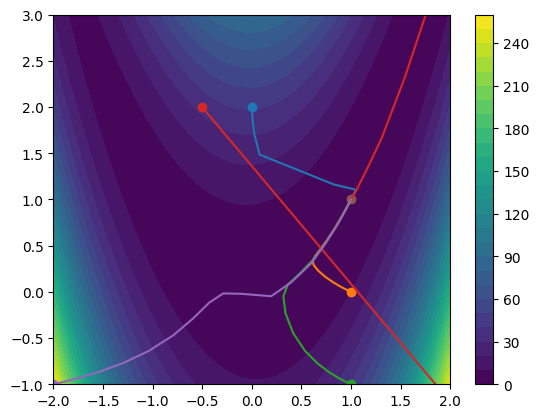

In [81]:
xar = np.linspace(ax, bx, 1000) #x,y taken by sympy
yar = np.linspace(ay, by, 1000)
X, Y = np.meshgrid(xar,yar)

Z = contour_mf((X, Y))


countour = plt.contourf(X, Y, Z, levels=30)
cbar = plt.colorbar(countour)

for x0 in x0_list:
    plt.scatter(*x0)
    status, result, steps, step_list = optimize_newton_raphson_lm(x0, mf, dmf, ddmf, max_iter=1000, is_verbose=True)
    path = np.array(step_list)
    plt.plot(path[:,0], path[:,1])

plt.scatter(xtrue[0], xtrue[1])
plt.xlim(ax, bx)
plt.ylim(ay, by)

## Conjugate gradient method for symmetric positive-definite linear systems

**Task 3.** Program the conjugate gradient method for solving a linear system $A\vec{x}=\vec{b}$.


In [87]:
# solve a linear system Ax=b with the conjugate gradient algorithm,
# relative and absolute tolerances are interpreted as in SciPy
# Input:
# A -- symmetric positive-definite n*n matrix,
# b -- r.h.s. vector of size n,
# x0 -- initial guess vector of size n
# rtol, atol -- relative and absolute tolerance, for the loop condition:
#               repeat while |r| > max( rtol*|b|, atol ),
# max_iter -- maximum number of iterations.
# Output: comma separated list of the following 
# status -- =0 on success, =1 if exceeded the maximum number of iterations,
# x -- solution vector,
# number of iterations,
# list of all intermediate x values visited by the algorithm.
def solve_CG( A, b, x0, rtol=1e-5, atol=0, max_iter=5000 ):

    # dimensionality
    n = len( x0 )
    
    # r.h.s. norm for comparisons
    bnorm = np.linalg.norm( b )

    # initial residual
    r = A.dot(x0) - b

    # initial direction
    p = -r.copy()
    # starting point
    x = x0.copy()

    r2 = r@r
    xlist = [x.copy()]

    for k in range(max_iter):
        Ap = A @ p
        alpha = r2 / np.dot(p, Ap)
        x = x + alpha * p
        r = r + alpha * Ap  # Flipping the residual update
        r2new = np.dot(r, r)
        
        xlist.append(x.copy())
        
        if np.linalg.norm(r) <= max(rtol * bnorm, atol):
            return 0, x, k + 1, xlist
        
        beta = r2new / r2
        p = -r + beta * p  # Flipping p explicitly
        r2 = r2new
    
    return 1, x, max_iter, xlist


**Task 4.** Test the conjugate gradient method on the system given below:

$$
A=\left[\begin{array}{rrr}
5 & 3 & 0 \\
3 & 4 & 1 \\
0 & 1 & 5
\end{array}\right],
\,\,\,\,\,\,\,
b=\left[\begin{array}{r}
21 \\
18 \\
7
\end{array}\right].
$$

Find the solution of this linear system to compare to the results of your conjugate gradient function. Test your function with different initial guesses $x_0$, e.g., $[0\ 0\ 0]^T$, $[1\ 1\ 1]^T$, $[100\ 100\ 100]^T$, etc. Experiment with different `rtol` parameter values.


In [98]:
A = np.array( [[5,3,0],[3,4,1],[0,1,5]], dtype=float )
b = np.array( [ 21, 18, 7 ], dtype=float )


solve_CG(A, b, x0=np.array([100,0,100]), rtol=1e-15)

(0,
 array([3., 2., 1.]),
 4,
 [array([100,   0, 100]),
  array([ 32.99192791, -53.43858776,  31.03344564]),
  array([ 33.30485894, -29.66676806,   1.77069844]),
  array([3., 2., 1.]),
  array([3., 2., 1.])])

&#169; Copyright 2025,  Michigan State University Board of Trustees